## Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет **температуру стали**.

## Исследовательский анализ данных. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance

In [3]:
import lightgbm as lgbm

In [4]:
random_state  = 110923

### Задача

- Объект моделирования - один ковш
- Его определяет уникальный ключ (столбец key)

Целевая переменная - **последняя температура по всей партии**

Целевая метрика - MAE (не больше 6.8 на тесте)

- data_arc_new.csv
- data_bulk_new.csv
- data_bulk_time_new.csv
- data_gas_new.csv
- data_temp_new.csv
- data_wire_new.csv
- data_wire_time_new.csv

### Цель:

Научиться предсказывать последнюю температуру по всей партии, чтобы снизить затраты на электричество и обслуживание.


In [6]:
#Загрузим данные

arc = pd.read_csv('/datasets/data_arc_new.csv')
bulk = pd.read_csv('/datasets/data_bulk_new.csv')
bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
gas = pd.read_csv('/datasets/data_gas_new.csv')
temp = pd.read_csv('/datasets/data_temp_new.csv')
wire = pd.read_csv('/datasets/data_wire_new.csv')
wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')


In [7]:
def data_overview(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print("Пропуски:", data.isna().sum())
    print("Явные дубликаты:", data.duplicated().sum())
    print('')
    colnames = data.select_dtypes('number').columns
    for name in colnames:
            data[name].plot.hist(bins = 100)
            plt.title(name)
            plt.show()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Пропуски: key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
Явные дубликаты: 0



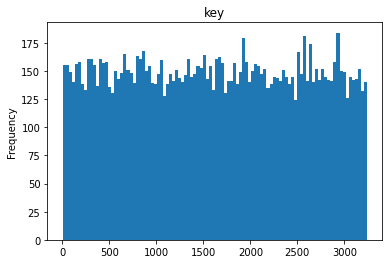

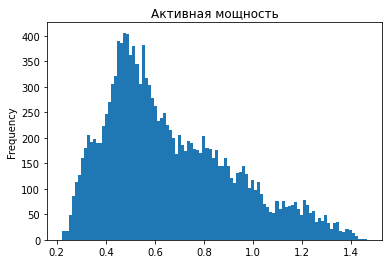

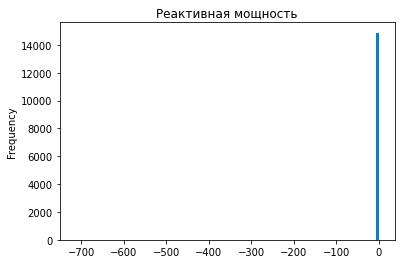

In [8]:
data_overview(arc)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Пропуски: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
Явные дубликаты: 0



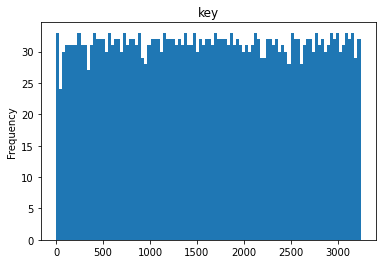

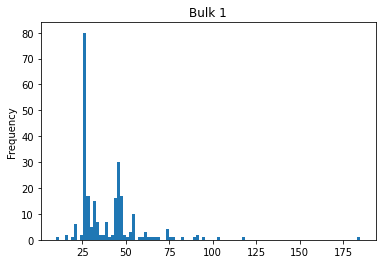

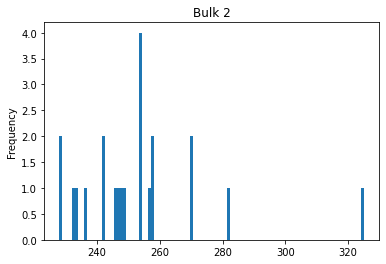

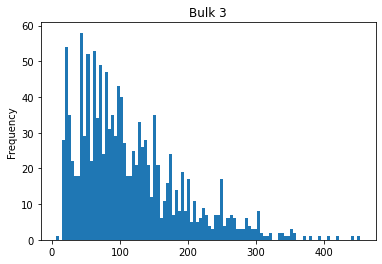

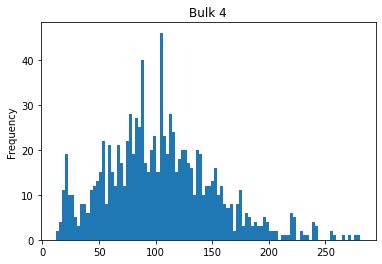

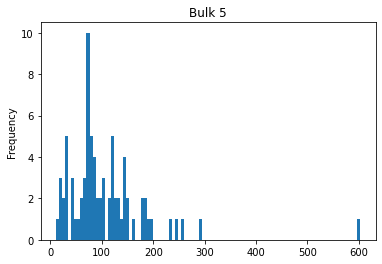

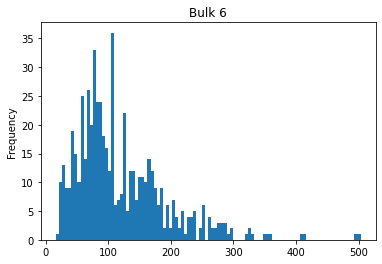

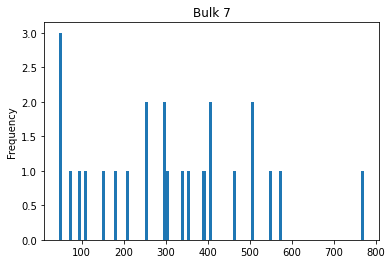

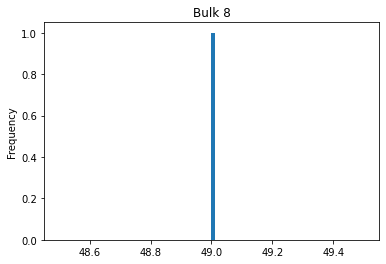

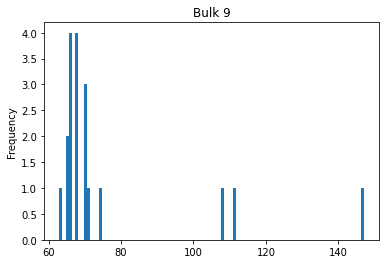

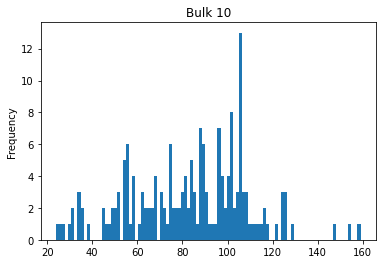

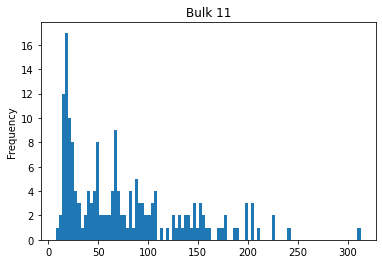

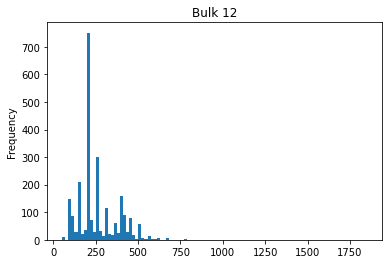

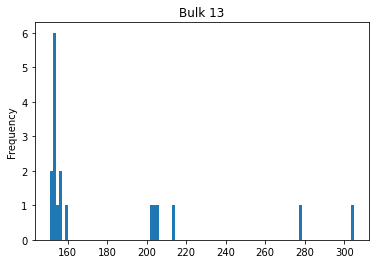

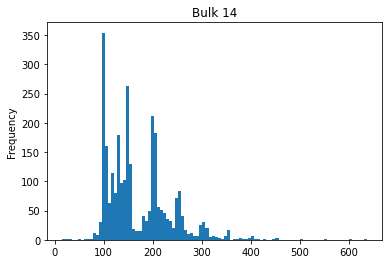

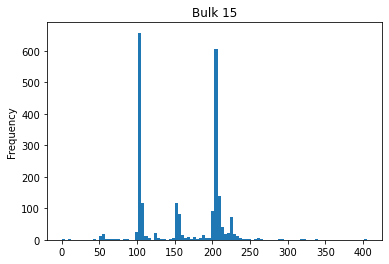

In [9]:
data_overview(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Пропуски: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
Явные дубликаты: 0



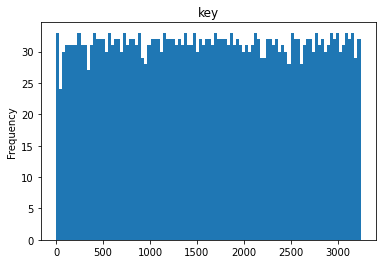

In [10]:
data_overview(bulk_time)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Пропуски: key      0
Газ 1    0
dtype: int64
Явные дубликаты: 0



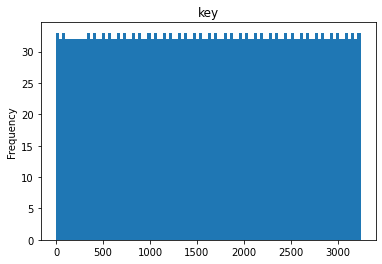

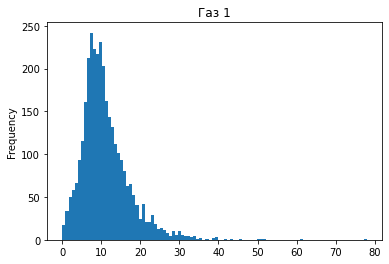

In [11]:
data_overview(gas)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Пропуски: key                0
Время замера       0
Температура     3427
dtype: int64
Явные дубликаты: 0



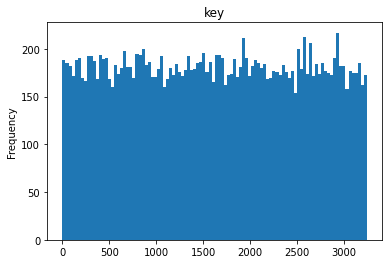

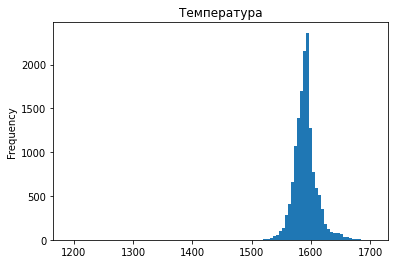

In [12]:
data_overview(temp)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Пропуски: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
Явные дубликаты: 0



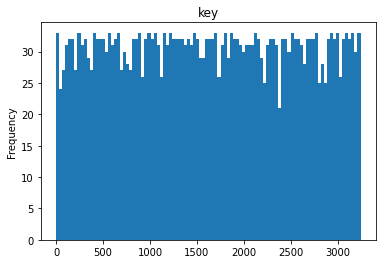

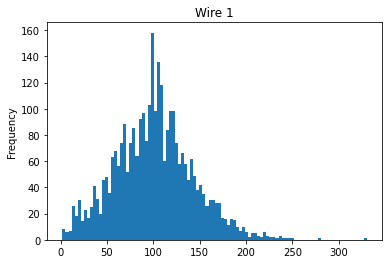

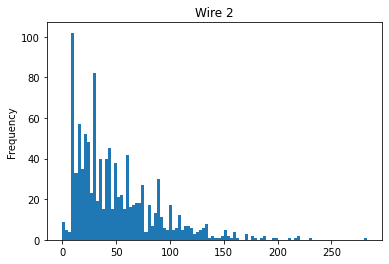

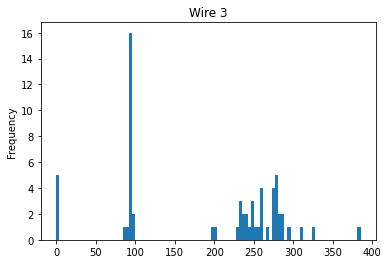

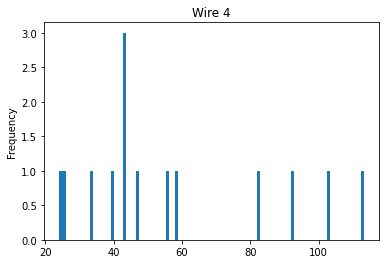

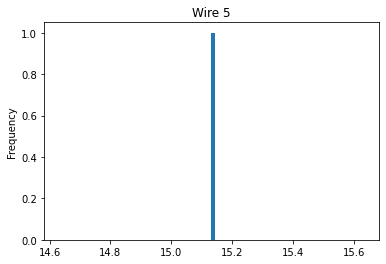

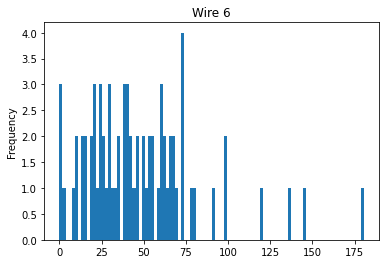

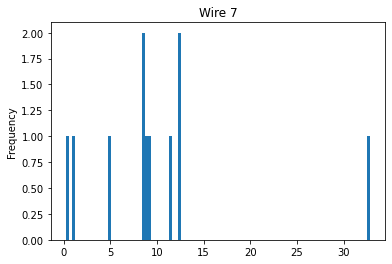

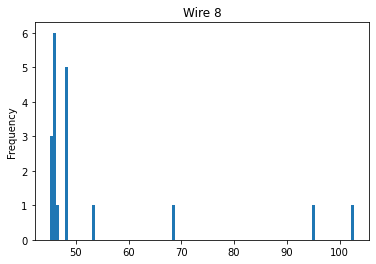

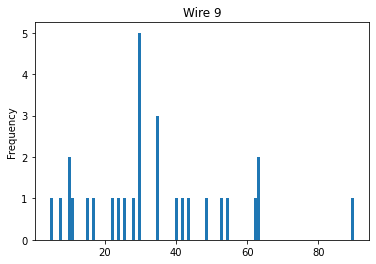

In [13]:
data_overview(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Пропуски: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
Явные дубликаты: 0



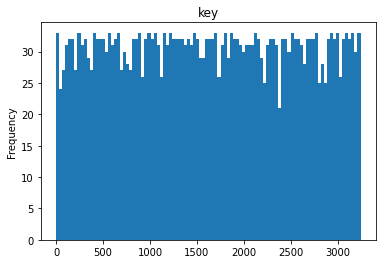

In [14]:
data_overview(wire_time)

### Выводы по исследовательскому анализу данных:

- В некоторых датасетах (в данных о подаче сыпучих материалов, в данных о проволочных материалах) мы видим много пропусков. Нужно будет принять решение о том, как их обработать и насколько важны эти признаки для дальнейшей работы.
- В данных об электродах явно есть аномалии в столбце "реактивная мощность" (большое отрицательное значение) - нужно будет определить его природу и обработать. 
- Мы видим, что в датасете об электродах как будто больше данных, чем во всех остальных. Это связано с тем, что там ковш-ключ встречается несколько раз - после разных этапов нагрева дугой. Нужно будет принять решение о том, как аггрегировать эти данные для использования в итоговом датасете признаков.


### План работы:

1) Объединить таблицы по столбцу key. Берем только те партии, которые присуствуют во все таблицах. Перед объединением аггрегировать данные в таблице данных с электродов. Исследовать полученный датасет

2) Обработать пропуски и явные аномалии (не выбросы!) в полном датасете. Удалить признаки, где пропуски занимают больше 80% данных. По завершению исследования датасета удалить столбец key

3) Разделить выборку на данные для обучения с использованием кросс-валидации (0.75) и теста (0.25)

4) Обработать выбросы на обучающей выборке, провести масштабирование на обучающей выборке, удалить признаки с высокой кореляцией (для линейной регресси)

5) Провести кросс-валидацию нескольких разных моделей, отобрать лучшую по метрике MAE

6) Провести тестирование лучшей модели на тестовой выборке

7) Написать отчет по работе


**Уточняющие вопросы к заказчику:**
- С чем может быть связано такое количество пропусков в данных о сыпучих и проволочных материалов? Насколько эти данные важны в процессе производства?

## Основная часть

### Объединение таблиц

У нас есть таблицы: arc, gas, bulk, bulk_time, wire, wire_time, temp

Таблицу по электродам (arc) нужно аггрегировать перед объединением. Возьмем средние значения по ковшу. Перед этим исключим ковш с отрицательным значением.

In [15]:
arc[arc['Реактивная мощность']< 0]['key']

9780    2116
Name: key, dtype: int64

In [16]:
arc = arc[arc['key'] != 2116]

In [17]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Сразу создадим здесь новые признаки:
- Длительность нагрева дугой (разница между началом нагрева дугой и концом нагрева дугой в минутах)
- Число циклов нагрева для каждого ковша (сколько раз ключ ковша встречается а таблице электродов)
- Полная мощность (вычисляется как корень из суммы квадратов активной и реактивной мощности) 

In [18]:
#Длительность нагрева дугой (средняя для ковша)
#(разница между началом нагрева дугой и концом нагрева дугой в минутах)
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

arc['heat_duration'] = \
(arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.seconds / 60


In [19]:
arc_agg = pd.pivot_table(arc, index = 'key', \
                    values = ['Активная мощность', 'Реактивная мощность', 'heat_duration'],\
                    aggfunc = 'mean')
arc_agg.columns = ['heat_duration','active_power', 'reactive_power']

In [20]:
arc_agg['full_power'] = np.sqrt(arc_agg['active_power']**2\
                                + arc_agg['reactive_power']**2)

In [21]:
arc_agg['heated_count'] = arc.groupby(['key'])['key'].count()

In [22]:
arc_agg.head()

,heat_duration,active_power,reactive_power,full_power,heated_count
key,,,,,
1,3.660000,0.607346,0.428564,0.743328,5
2,3.379167,0.534852,0.363339,0.646593,4
3,2.183333,0.812728,0.587491,1.002833,5
4,3.087500,0.676622,0.514248,0.849864,4
5,3.620833,0.563238,0.421998,0.703789,4


Из таблицы температур нам нужно достать первую температуру (признак) и последнюю температуру (**целевой** признак) ковша

In [23]:
temp.head()
#Датасет уже отсортирован по времени замера.
#Возьмем первое появление ключа в датасете как первую температуру

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [24]:
first_temp_index = []
first_temp_keys = []
for i in range(temp.shape[0]):
    key = temp['key'][i]
    if key not in first_temp_keys:
        first_temp_index.append(i)
        first_temp_keys.append(key)

In [25]:
first_temp = temp.loc[first_temp_index]
first_temp['Время замера'] = pd.to_datetime(first_temp['Время замера'])
first_temp.info()
first_temp.reset_index(inplace = True, drop = True)
display(first_temp.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3216 non-null   int64         
 1   Время замера  3216 non-null   datetime64[ns]
 2   Температура   3216 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 100.5 KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,2,2019-05-03 11:34:04,1581.0
2,3,2019-05-03 12:06:44,1596.0
3,4,2019-05-03 12:39:27,1601.0
4,5,2019-05-03 13:11:03,1576.0


In [26]:
last_temp_index = []
for i in range(1,temp.shape[0]):
    key = temp['key'][i]
    if key != temp['key'][i-1]:
        last_temp_index.append(i-1)

In [27]:
last_temp = temp.loc[last_temp_index]
last_temp['Время замера'] = pd.to_datetime(last_temp['Время замера'])
last_temp.info()
last_temp.reset_index(inplace = True, drop = True)
display(last_temp.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3215 entries, 5 to 18085
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3215 non-null   int64         
 1   Время замера  3215 non-null   datetime64[ns]
 2   Температура   2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 100.5 KB


,key,Время замера,Температура
0,1,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:36:39,1602.0


Теперь создадим новый признак из по температуре:

- Разницу между замерами первой и последней температуры (в минутах)

In [28]:
#Разница между замерами первой и последней температуры (в минутах)

temp_delta = pd.DataFrame(last_temp['Время замера'] - first_temp['Время замера'])
temp_delta['key'] = last_temp['key']
temp_delta['time_temp_delta'] = temp_delta['Время замера'].dt.seconds / 60
temp_delta.drop('Время замера', axis = 1, inplace = True)
temp_delta.head()

,key,time_temp_delta
0,1.0,28.566667
1,2.0,21.083333
2,3.0,29.216667
3,4.0,20.333333
4,5.0,25.600000


In [29]:
first_temp.drop('Время замера', axis = 1, inplace = True)
last_temp.drop('Время замера', axis = 1, inplace = True)
first_temp.columns = ['key', 'first_temp']
last_temp.columns = ['key', 'last_temp']

------------------------------------
Теперь можно объединять таблицы.

In [30]:
df = arc_agg.merge(gas, how = 'inner', on = 'key')
df = df.merge(first_temp, how = 'inner', on = 'key')
df = df.merge(last_temp, how = 'inner', on = 'key')
df = df.merge(temp_delta, how = 'inner', on = 'key')
df = df.merge(bulk, how = 'inner', on = 'key')
df = df.merge(wire, how = 'inner', on = 'key')

In [31]:
#Стандартизируем названия признаков

columns_names = df.columns
new_columns_names = ['key', 'heat_duration', 'active_power', 'reactive_power', 'full_power',
       'heated_count', 'gas', 'first_temp', 'last_temp', 'time_temp_delta',
       'Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6', 'Bulk_7',
       'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11', 'Bulk_12', 'Bulk_13',
       'Bulk_14', 'Bulk_15', 'Wire_1', 'Wire_2', 'Wire_3', 'Wire_4', 'Wire_5',
       'Wire_6', 'Wire_7', 'Wire_8', 'Wire_9']
df.columns = new_columns_names
df.columns = df.columns.str.lower()
display(df.head())
df.info()

,key,heat_duration,active_power,reactive_power,full_power,heated_count,gas,first_temp,last_temp,time_temp_delta,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,3.660000,0.607346,0.428564,0.743328,5,29.749986,1571.0,1613.0,28.566667,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3.379167,0.534852,0.363339,0.646593,4,12.555561,1581.0,1602.0,21.083333,...,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2.183333,0.812728,0.587491,1.002833,5,28.554793,1596.0,1599.0,29.216667,...,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.087500,0.676622,0.514248,0.849864,4,18.841219,1601.0,1625.0,20.333333,...,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3.620833,0.563238,0.421998,0.703789,4,5.413692,1576.0,1602.0,25.600000,...,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3020 entries, 0 to 3019
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3020 non-null   int64  
 1   heat_duration    3020 non-null   float64
 2   active_power     3020 non-null   float64
 3   reactive_power   3020 non-null   float64
 4   full_power       3020 non-null   float64
 5   heated_count     3020 non-null   int64  
 6   gas              3020 non-null   float64
 7   first_temp       3020 non-null   float64
 8   last_temp        2328 non-null   float64
 9   time_temp_delta  3020 non-null   float64
 10  bulk_1           252 non-null    float64
 11  bulk_2           22 non-null     float64
 12  bulk_3           1293 non-null   float64
 13  bulk_4           1012 non-null   float64
 14  bulk_5           77 non-null     float64
 15  bulk_6           569 non-null    float64
 16  bulk_7           24 non-null     float64
 17  bulk_8        

Единый датасет готов, займемся предобработкой.

### Подготовка полного датасета

Сразу можно выбросить ключи у которых пропуски в значении целевого признака (last_temp)

In [32]:
df = df.dropna(subset=['last_temp'])

Далее избавимся от признаков, в которых более 80% пропусков.

In [33]:
bad_cols = []
for col in df.columns:
    if (df[col].isna().sum()/df.shape[0])*100 >=80:
        bad_cols.append(col)
df = df.drop(bad_cols, axis = 1)

В оставшихся признаках заменим пропуски на 0 и избавимся от колоники key.

In [34]:
df = df.fillna(value = 0)

In [35]:
df.tail()

,key,heat_duration,active_power,reactive_power,full_power,heated_count,gas,first_temp,last_temp,time_temp_delta,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
2323,2495,3.012500,0.792033,0.552734,0.965832,4,7.125735,1570.0,1591.0,23.000000,21.0,0.0,256.0,129.0,223.0,89.150879,0.00000
2324,2496,2.611111,0.695820,0.478672,0.844566,6,9.412616,1554.0,1591.0,28.416667,0.0,63.0,256.0,129.0,226.0,114.179527,0.00000
2325,2497,3.161111,1.201746,0.817364,1.453368,3,6.271699,1571.0,1589.0,16.033333,0.0,85.0,230.0,124.0,226.0,94.086723,9.04800
2326,2498,2.500000,0.640462,0.447964,0.781577,5,14.953657,1591.0,1594.0,25.333333,90.0,0.0,206.0,129.0,207.0,118.110717,0.00000
2327,2499,3.679167,0.434271,0.324209,0.541944,4,11.336151,1569.0,1603.0,25.616667,47.0,0.0,233.0,126.0,227.0,110.160958,50.00528


In [36]:

df = df.drop('key', axis = 1)

-------------
Посмотрим на датасет целиком.

In [37]:
def data_overview_full(data):
    display(data.head())
    display(data.info())
    print("Пропуски:", data.isna().sum())
    print("Явные дубликаты:", data.duplicated().sum())
    print('')
    colnames = data.select_dtypes('number').columns
    for name in colnames:
            data[name].plot.hist(bins = 100)
            plt.title(name)
            plt.show()
            
    print("Таблица корреляций Пирсона для всех численных переменных")
    print(data.corr())
    print('')

,heat_duration,active_power,reactive_power,full_power,heated_count,gas,first_temp,last_temp,time_temp_delta,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,3.660000,0.607346,0.428564,0.743328,5,29.749986,1571.0,1613.0,28.566667,0.0,43.0,206.0,150.0,154.0,60.059998,0.00000
1,3.379167,0.534852,0.363339,0.646593,4,12.555561,1581.0,1602.0,21.083333,0.0,73.0,206.0,149.0,154.0,96.052315,0.00000
2,2.183333,0.812728,0.587491,1.002833,5,28.554793,1596.0,1599.0,29.216667,0.0,34.0,205.0,152.0,153.0,91.160157,0.00000
3,3.087500,0.676622,0.514248,0.849864,4,18.841219,1601.0,1625.0,20.333333,0.0,81.0,207.0,153.0,154.0,89.063515,0.00000
4,3.620833,0.563238,0.421998,0.703789,4,5.413692,1576.0,1602.0,25.600000,0.0,78.0,203.0,151.0,152.0,89.238236,9.11456


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   heat_duration    2328 non-null   float64
 1   active_power     2328 non-null   float64
 2   reactive_power   2328 non-null   float64
 3   full_power       2328 non-null   float64
 4   heated_count     2328 non-null   int64  
 5   gas              2328 non-null   float64
 6   first_temp       2328 non-null   float64
 7   last_temp        2328 non-null   float64
 8   time_temp_delta  2328 non-null   float64
 9   bulk_3           2328 non-null   float64
 10  bulk_4           2328 non-null   float64
 11  bulk_12          2328 non-null   float64
 12  bulk_14          2328 non-null   float64
 13  bulk_15          2328 non-null   float64
 14  wire_1           2328 non-null   float64
 15  wire_2           2328 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 309.2 KB


None

Пропуски: heat_duration      0
active_power       0
reactive_power     0
full_power         0
heated_count       0
gas                0
first_temp         0
last_temp          0
time_temp_delta    0
bulk_3             0
bulk_4             0
bulk_12            0
bulk_14            0
bulk_15            0
wire_1             0
wire_2             0
dtype: int64
Явные дубликаты: 0



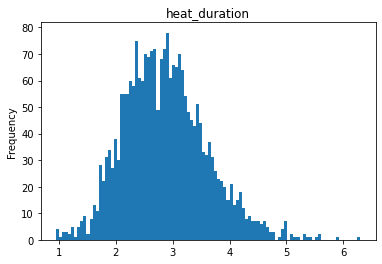

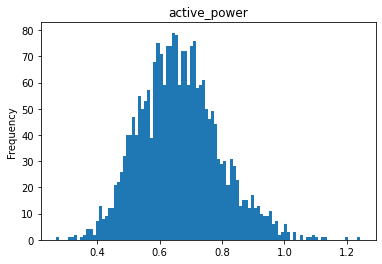

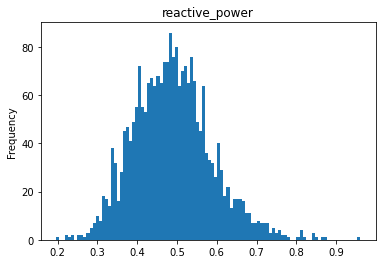

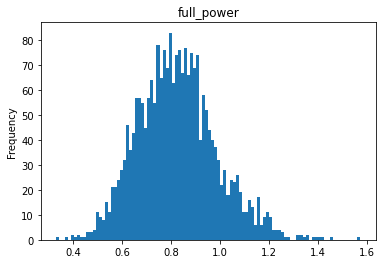

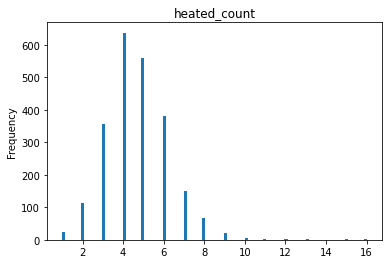

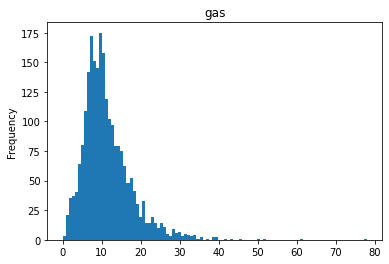

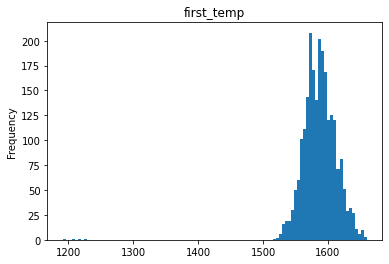

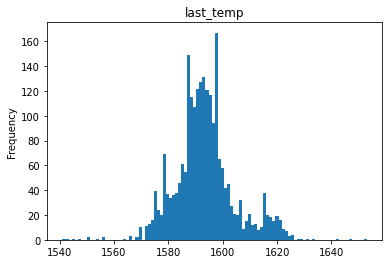

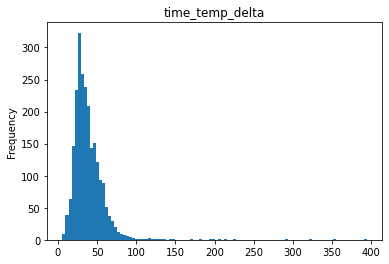

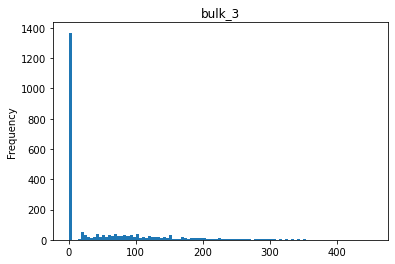

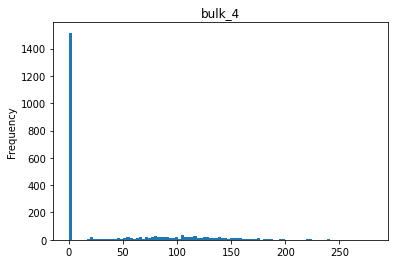

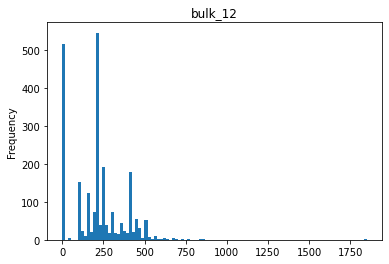

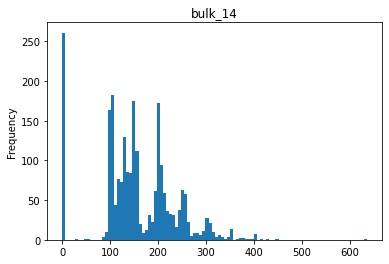

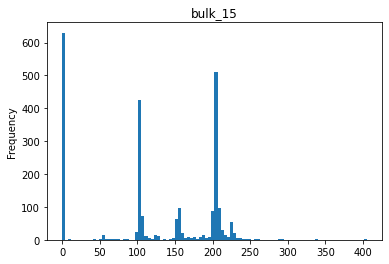

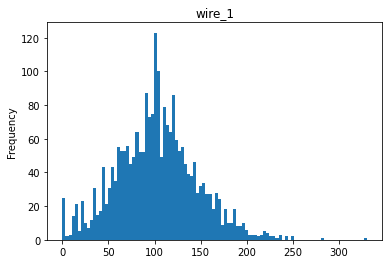

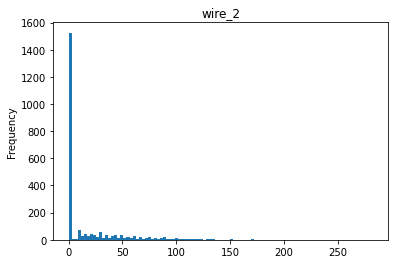

Таблица корреляций Пирсона для всех численных переменных
                 heat_duration  active_power  reactive_power  full_power  \
heat_duration         1.000000      0.035033        0.023048    0.030897   
active_power          0.035033      1.000000        0.965362    0.995471   
reactive_power        0.023048      0.965362        1.000000    0.985787   
full_power            0.030897      0.995471        0.985787    1.000000   
heated_count         -0.002198      0.033926        0.032369    0.033032   
gas                   0.102054      0.040258        0.041628    0.040870   
first_temp           -0.347077      0.004226        0.001953    0.003541   
last_temp             0.193440      0.040140        0.032878    0.037739   
time_temp_delta       0.055850      0.025469        0.024668    0.025146   
bulk_3                0.017792      0.027347        0.023217    0.026043   
bulk_4               -0.038965      0.022380        0.022909    0.022711   
bulk_12               0.370725 

In [38]:
data_overview_full(df)

Между некоторыми переменными мы вижим довольно высокие корреляции, посмотрим на хитмап.

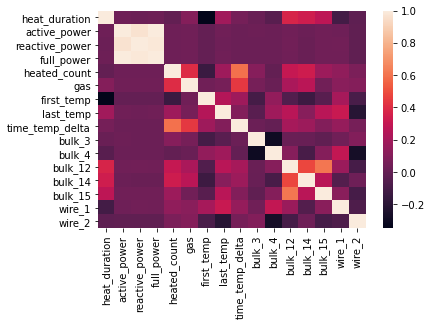

In [39]:
corr = df.select_dtypes('number').corr()
sns.heatmap(corr)
plt.show()

Ага, видим высокие корреляции между признаками активная мощность, реактивная мощность и полная мощность, что логично. Удалим реактивную и активную мощность, так ка кинформация о них по сути содержится теперь в признаке полная мощность.

In [40]:
df = df.drop(['active_power', 'reactive_power'], axis = 1)

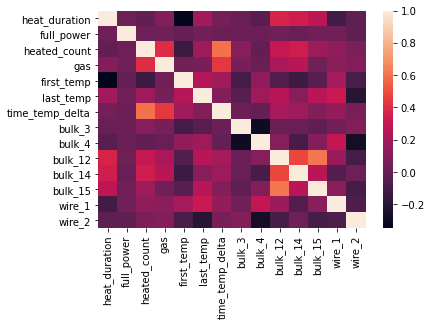

In [41]:
corr = df.select_dtypes('number').corr()
sns.heatmap(corr)
plt.show()

### Обучение моделей

Разделим датасеты на признаки и таргет, а затем на обучающую и тестовую выборку.

In [42]:
features = df.drop('last_temp', axis = 1)
target = df['last_temp']

In [43]:
features_train, features_test,target_train, target_test  = train_test_split(\
                          features,target,test_size=0.25, random_state=random_state)

In [44]:
display(features_train.head())
print(features_train.shape)
print(features_test.shape)

,heat_duration,full_power,heated_count,gas,first_temp,time_temp_delta,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
2129,1.986111,0.765591,6,15.619964,1628.0,48.583333,0.0,88.0,256.0,99.0,104.0,118.198082,9.16864
268,3.533333,0.882306,6,5.940925,1569.0,40.100000,89.0,0.0,521.0,330.0,202.0,45.077759,10.13376
980,3.564286,0.947466,7,4.814961,1574.0,59.900000,121.0,0.0,206.0,152.0,101.0,157.014000,0.00000
985,1.641667,0.970887,4,10.453137,1606.0,43.616667,163.0,0.0,177.0,131.0,0.0,112.881599,0.00000
1143,1.791667,0.841638,4,11.485524,1622.0,40.816667,66.0,64.0,106.0,103.0,101.0,157.107605,0.00000


(1746, 13)
(582, 13)


Масштабируем признаки для использования в линейных моделях.

In [45]:
scaler = StandardScaler()
scaler.fit(features_train) #fitting scaler
features_train = pd.DataFrame(scaler.transform(features_train)) 
features_test = pd.DataFrame(scaler.transform(features_test))

In [46]:
features_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.223995,-0.374211,0.805414,0.677255,1.495352,0.418907,-0.632602,0.893040,0.301740,-0.699789,-0.199972,0.375867,-0.257172
1,0.880931,0.356897,0.805414,-0.858833,-0.607699,0.062730,0.565800,-0.622749,2.025579,2.179450,0.953742,-1.291261,-0.228820
2,0.923040,0.765058,1.425729,-1.037526,-0.429475,0.894043,0.996687,-0.622749,-0.023513,-0.039185,-0.235290,1.260862,-0.526525
3,-1.692597,0.911770,-0.435215,-0.142733,0.711164,0.210379,1.562225,-0.622749,-0.212159,-0.300934,-1.424323,0.254653,-0.526525
4,-1.488528,0.102149,-0.435215,0.021109,1.281483,0.092820,0.256101,0.479643,-0.674018,-0.649932,-0.235290,1.262996,-0.526525


In [47]:
#словари параметров для гридсерчей
param_grid_dt = {'max_depth': range(1,15,5)}
param_grid_gb = {"max_depth": range(1,15,5),
    "num_leaves": range(10, 100, 10)}
param_grid_lr = {"fit_intercept": [True] 
             }

In [48]:
%%time
lr_search = GridSearchCV(linear_model.LinearRegression(), cv = 5, \
                         param_grid = param_grid_lr, \
                         scoring = 'neg_mean_absolute_error')
lr_search.fit(features_train, target_train)
lr_search.cv_results_

print('MAE линейной регресии на кросс-валидации:', lr_search.best_score_)

print('Время обучения линейной регресии:')

MAE линейной регресии на кросс-валидации: -6.660885870223406
Время обучения линейной регресии:
CPU times: user 42.8 ms, sys: 66.4 ms, total: 109 ms
Wall time: 68.7 ms


In [49]:
%%time
dt_search = GridSearchCV(DecisionTreeRegressor(), cv = 5, \
             param_grid = param_grid_dt, scoring = 'neg_mean_absolute_error')
dt_search.fit(features_train, target_train)
dt_search.cv_results_
print('MAE дерева решений на кросс-валидации:', dt_search.best_score_)

print('Время обучения дерева решений:')

MAE дерева решений на кросс-валидации: -7.386127593461613
Время обучения дерева решений:
CPU times: user 223 ms, sys: 34.9 ms, total: 258 ms
Wall time: 271 ms


In [50]:
%%time
gb_search = GridSearchCV(lgbm.LGBMRegressor(random_seed=random_state), cv = 5, \
                         param_grid = param_grid_dt, scoring = 'neg_mean_absolute_error')
gb_search.fit(features_train, target_train)
gb_search.cv_results_
print('MAE градиентного бустинга на кросс-валидации:', gb_search.best_score_)
print('Время обучения градиентного бустинга:')

MAE градиентного бустинга на кросс-валидации: -6.213547288204251
Время обучения градиентного бустинга:
CPU times: user 7min 40s, sys: 3.91 s, total: 7min 44s
Wall time: 7min 48s


Лучшая модель по кросс-валидации - Градиентный бустинг. Протестируем его на тестовой выборке и сравним с DummyRegressor

### Тестирование лучшей модели и анализ признаков

In [55]:
%%time
gb_mae_test = mean_absolute_error(gb_search.best_estimator_.predict(features_test)\
                                  , target_test)
print('MAE градиентного бустинга на тестовой выборке:', gb_mae_test)

MAE градиентного бустинга на тестовой выборке: 6.319847447399135
CPU times: user 11.7 ms, sys: 2 µs, total: 11.7 ms
Wall time: 6.7 ms


In [56]:
gb_r2_test = r2_score(target_test, gb_search.best_estimator_.predict(features_test))
print('R-squared градиентного бустинга на тестовой выборке:', gb_r2_test)

R-squared градиентного бустинга на тестовой выборке: 0.45111765390142033


Сравним с dummy regressor:

In [57]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
print('MAE дамми-модели на тестовой выборке:', 
      mean_absolute_error(dummy_regr.predict(features_test), target_test))
print('R-squared дамми-модели на тестовой выборке:', 
      r2_score(target_test, dummy_regr.predict(features_test)))


MAE дамми-модели на тестовой выборке: 8.070806910641112
R-squared дамми-модели на тестовой выборке: -0.0014015447949955462


Наша модель лучше дамми-модели, что не может не радовать. Метрика MAE меньше заданных заказчиков 6.8, однако метрика R-squared все же довольно низкая - всего 0.45.

Посмотрим на значение признаков.

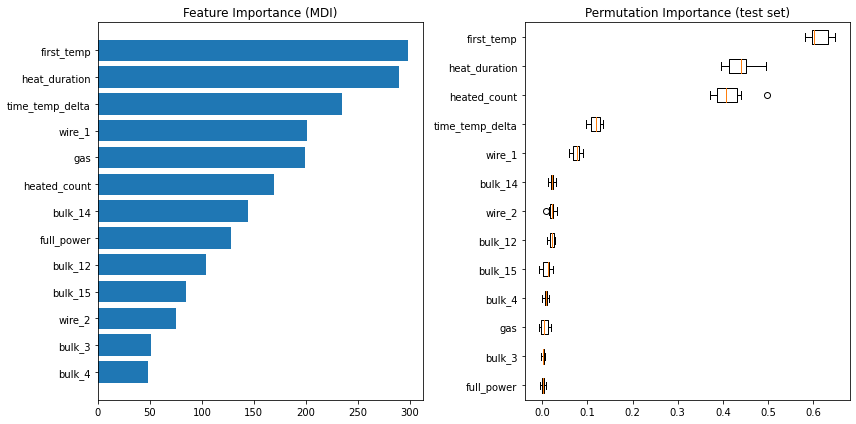

In [58]:
feature_importance = gb_search.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gb_search.best_estimator_, features_test, target_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

**Анализ признаков:**

Самыми важными признаками по оценке двух различных методов оказались первая температура и продолжительность нагрева.
    

## Отчет по решению

**Цель проекта:**

Научиться предсказывать последнюю температуру по всей партии, чтобы снизить затраты на электричество и обслуживание. 

**Задача:**

Объектом моделирования является один ковш (определяется по ключу key), целевой признак - последняя температура по ковшу. Задача: предсказание последней температуры ковша по остальным признакам.

### Сравнение плана и решения

**Первоначальный план:** 

1) Объединить таблицы по столбцу key. Берем только те партии, которые присуствуют во все таблицах. Перед объединением аггрегировать данные в таблице данных с электродов. Исследовать полученный датасет

2) Обработать пропуски и явные аномалии (не выбросы!) в полном датасете. Удалить признаки, где пропуски занимают больше 80% данных. По завершению исследования датасета удалить столбец key

3) Разделить выборку на данные для обучения с использованием кросс-валидации (0.75) и теста (0.25)

4) Обработать выбросы на обучающей выборке, провести масштабирование на обучающей выборке, удалить признаки с высокой кореляцией (для линейной регрессии)

5) Провести кросс-валидацию нескольких разных моделей, отобрать лучшую по метрике MAE

6) Провести тестирование лучшей модели на тестовой выборке

**Практически все пункты из плана выше были выполнены.**

Объединили таблицы по столбцу key, взяв только те партии, которые присуствовали во всех датасетах. Перед объединением данные в таблице электродов были аггрегированы - взяли средние значения по ковшу. После объединения было проведено исследование датасета, после чего удалены явные аномалии и признаки с 80 и более процентов пропусков. Столбец key был удален после дополнительной проверки (не должно было остаться ключей выше 2499).

Далее мы разделили датасет на таргет и признаки и разделили выборку на данные для обучения с использованием кросс-валидации (0.75) и теста (0.25). После разделения выборок дополнительно проверили размер получившихься датасетов.

**Расхождение с планом**: Так как в ходе исследования датасета было обнаружено, что явных выбросов в признаках нет, их обработка не производилась на обучающей выборке. 

Мы провели масштабирование данных, настроив scaler на обучающей выборке и удалили признаки с высокой взаимной корреляцией. Мы взяли в качестве порога меру корреляции Пирсона > 0.8, этот порог попали признаки активная мощность, реактивная мощность и полная мощность. Активная мощность и реактивная мощность были удалены, так как информация о них содержится в признаке полная мощность (см. далее).

Мы провели кросс-валидацию **трех** моделей: линейная регрессия, дерево решений и градиентный бустинг с подбором гиперпараметров. Лучшая модель по метрики MAE (градиентный бустинг) была протестирована на тестовой выборке и преодолела порог, выставленный клиентом. 

---
**Помимо указанных в изначальном плане пунктов были выполнены следующие шаги:**

- Перед объединением таблицы мы получили из таблицы данных с электродов три дополнительных признака: длительность нагрева дугой, число циклов нагрева для ковша и полную мощность (см. раздел 4.3). Также из таблицы данных о замере температур был получен целевой признак - Последняя температура замера - и два предсказательных признака: первая температура замера и разница между замерами первой и последней температуры. 

- После проведения тестирования итоговой модели также была подсчитана метрика R-squared для дополнительной интерпретации результатов модели. Помимо этого было проведено сравнение результатов модели с dummy моделью (предсказывавшей среднее) для оценки адекватности модели.

### Возникшие трудности и ключевые шаги решения

Благодаря подробному разъяснению задачи и деталей проекта от тимлида, трудностей в решении практически не возникло :) 

### Признаки итоговой модели

Важно отметить, что в итоговый датасет попали только те ковши (по ключу key), у которых не было пропуска в целевом признаке - Последняя температура нагрева. Этот признак был получен из данных о замерах температур как последний замер температуры для ковша (по ключу key).

В итоговой модели использовались следующие предсказательные признаки:

- **first_temp**, Первая температура нагрева
- **heat_duration**, Длительность нагрева дугой 
- **time_temp_delta**, Разница между замерами первой и последней температуры (в минутах)
- **heated_cound**, Число циклов нагрева для каждого ковша
- **gas**, Данные о продувке сплава газом
- **full_power**, Полная мощность
- **wire_1**, Добавлено проволочных материалов в 1-й итерации
- **wire_2**, Добавлено проволочных материалов во 2-й итерации
- **bulk_4**, Добавлено сыпучих материалов в 4-й итерации
- **bulk_5**, Добавлено сыпучих материалов в 5-й итерации
- **bulk_12**, Добавлено сыпучих материалов в 12-й итерации
- **bulk_14**, Добавлено сыпучих материалов в 14-й итерации
- **bulk_15**, Добавлено сыпучих материалов в 15-й итерации

**Предобработка признаков**
- Первая температура нагрева была получена из данных о замерах температур как первый замер температуры для ковша (по ключу key).
- Длительность нагрева дугой была рассчитана по данным о замере электродов как усредненная по ковшу разница между началом нагрева дугой и концом нагрева дугой в минутах.
- Разница между замерами первой и последней температуры в минутах была получена из данных о замере температур, время замера первой и последней температуры взяты как первый и последний замер по ковшу (по ключу key).
- Число циклов нагрева для каждого ковша было рассчитано как число вхождения ключа ковша (key) в таблице данных с электродов.
- Данные о продувке газом получены из таблицы gas, мы не обнарудили в этих данных пропуски и аномалии, поэтому дополнительная обработка не проводилась.
- Полная мощность была получена из данных с электродов. Вычислялась как корень из суммы квадратов активной и реактивной мощности.
- Признаки о добавлении проволочных и сыпучих материалов содержали значительное число пропусков. Мы удалили из итогового датасета для обучения и проверки модели те признаки, где пропуски составили 80% данных и более. В оставшихься признаках пропуски были заменены на 0. 



### Описание итоговой модели

В качестве лучшей модели на кросс-валидации была отобрана модель градиентного бустинга, реализованная с помощью библиотеки lightgbm. Метрика MAE градиентного бустинга на тестовой выборке составила 6.32, а R-squared - 0.451. 

Мы перебрали различные значения максимальной глубины и числа "листьев" модели. Глубина итоговой модели = 6, а число "листьев" = 31. Везде использовался random_state = 110923.
Полный список гиперпараметров модели представлен ниже:

In [56]:
gb_search.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'random_seed': 110923}

При этом методы оценки важности признаков (среднее уменьшение точности и важность на основе перестановок) показали, что наибольшую роль в модели играют признаки первая температура и длительность нагрева дугой.